In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import pandas as pd
import numpy as np, os
import matplotlib.pyplot as plt
import math

from pathlib import Path
# import yaml
# import re
import datetime

# import pyarrow as pa
# import pyarrow.parquet as pq

# import gbd_mapping as gm
# from vivarium import Artifact

# from db_queries import get_ids, get_outputs, get_population, get_covariate_estimates
# from get_draws.api import get_draws

import vivarium_helpers as vh
# import vivarium_helpers.id_helper as idh
# from vivarium_helpers.vph_output.operations import VPHOperator
# from vivarium_helpers.vph_output.measures import VPHResults
from vivarium_helpers.utils import convert_to_categorical, constant_categorical, print_memory_usage, Timer
# from vivarium_helpers.vph_output import cleaning
# from vivarium_helpers.vph_output.loading import load_draws_from_keyspace_files
from vivarium_helpers.projects.alzheimers import loading, population
from vivarium_helpers.projects.alzheimers.population import RunType
# from vivarium_helpers.vph_artifact.operations import convert_to_sim_format
from vivarium_helpers.projects.alzheimers.results import AlzheimersResultsProcessor

# Define directories

In [3]:
# Project directory
project_dir = Path('/mnt/team/simulation_science/pub/models/vivarium_csu_alzheimers/')

# Output directory to store final results for client
output_dir = Path(r"J:\Project\simulation_science\alzheimers\results_in_progress".replace('\\', '/').replace('J:', '/snfs1'))
print(output_dir.exists())

# Output from multistate life table
mslt_output_dir = output_dir.parent / 'results_11_14_2025_mslt'
print(mslt_output_dir.exists())
output_dir

True
True


PosixPath('/snfs1/Project/simulation_science/alzheimers/results_in_progress')

In [4]:
# # For testing: Run directory containing model 8.3 results for all
# # locations
# model_run_subdir = 'results/abie_consistent_model_test/united_states_of_america/2025_10_28_08_55_05/'

# # Results directory for model 8.3, for testing
# results_dirs = project_dir / model_run_subdir / 'results/'

# Artifact for models 8.3 - 8.7
artifact_model_number = '8.3'

In [5]:
# Model 8.4 results (final runs for 10/31/25 intermediate results)
# Each batch run contains all locations, 100 random seeds, and 3 or 4 draws
model_run_dir_8_4 = Path('/mnt/team/simulation_science/pub/models/vivarium_csu_alzheimers/results/model8.4/model_spec')

# Model 8.7 results (updated final run completed on 11/10/2025)
model_run_dir_8_7 = Path('/mnt/team/simulation_science/pub/models/vivarium_csu_alzheimers/results/model8.7/model_spec')

# Batch runs are stored in "timestamp" subdirectories of the model run
# directory
# with os.scandir(model_run_dir_8_7) as entries:
#     batch_run_dirs_8_7 = [entry.path for entry in entries]
batch_run_dirs_8_7 = loading.list_paths(model_run_dir_8_7)

# Select a model and filter for testing
batch_run_dirs = batch_run_dirs_8_7[:1]

batch_run_dirs

['/mnt/team/simulation_science/pub/models/vivarium_csu_alzheimers/results/model8.7/model_spec/2025_11_05_15_36_29']

# Create a results object

In [6]:
results = AlzheimersResultsProcessor('8.3', RunType.FINAL, batch_run_dirs=batch_run_dirs)

In [7]:
results.draws

[457, 169, 323]

# Load population data

In [8]:
results.load_population_data()

In [9]:
results.person_time

,location,sex,event_year,input_draw,value,age_group
0,United States of America,Female,2025,457,1.121058e+07,25_to_29
1,United States of America,Female,2025,169,1.156020e+07,25_to_29
2,United States of America,Female,2025,323,1.051324e+07,25_to_29
3,United States of America,Female,2026,457,1.127173e+07,25_to_29
4,United States of America,Female,2026,169,1.162648e+07,25_to_29
...,...,...,...,...,...,...
68395,United Kingdom,Male,2100,169,3.839867e+05,90_to_94
68396,United Kingdom,Male,2100,323,3.869275e+05,90_to_94
68397,United Kingdom,Male,2100,457,1.446562e+05,95_plus
68398,United Kingdom,Male,2100,169,1.309761e+05,95_plus


In [11]:
# results.ops.compare_values(pt, results.person_time)

In [13]:
# ms

In [14]:
# results.ops.compare_values(ms, results.model_scale)

In [15]:
results.model_scale

,location,input_draw,value
0,Brazil,457,1.151080
1,Brazil,169,1.053388
2,Brazil,323,1.059915
3,China,457,0.125744
4,China,169,0.116177
5,China,323,0.112346
6,Germany,457,1.012328
7,Germany,169,0.912870
8,Germany,323,0.939648
9,Israel,457,43.913069


In [16]:
results.age_map

,age_group_id,age_group_name,age_start,age_end,age_group
0,10,25 to 29,25.0,30.0,25_to_29
1,11,30 to 34,30.0,35.0,30_to_34
2,12,35 to 39,35.0,40.0,35_to_39
3,13,40 to 44,40.0,45.0,40_to_44
4,14,45 to 49,45.0,50.0,45_to_49
5,15,50 to 54,50.0,55.0,50_to_54
6,16,55 to 59,55.0,60.0,55_to_59
7,17,60 to 64,60.0,65.0,60_to_64
8,18,65 to 69,65.0,70.0,65_to_69
9,19,70 to 74,70.0,75.0,70_to_74


In [17]:
results.age_map['age_group'].unique()

['25_to_29', '30_to_34', '35_to_39', '40_to_44', '45_to_49', ..., '75_to_79', '80_to_84', '85_to_89', '90_to_94', '95_plus']
Length: 15
Categories (15, object): ['25_to_29', '30_to_34', '35_to_39', '40_to_44', ..., '80_to_84', '85_to_89', '90_to_94', '95_plus']

In [18]:
sixty_plus_map = {'60_plus': [a for a in results.age_map['age_group'] if a >= '60_to_64']}
sixty_plus_map

{'60_plus': ['60_to_64',
  '65_to_69',
  '70_to_74',
  '75_to_79',
  '80_to_84',
  '85_to_89',
  '90_to_94',
  '95_plus']}

Germany 2040 Female 457


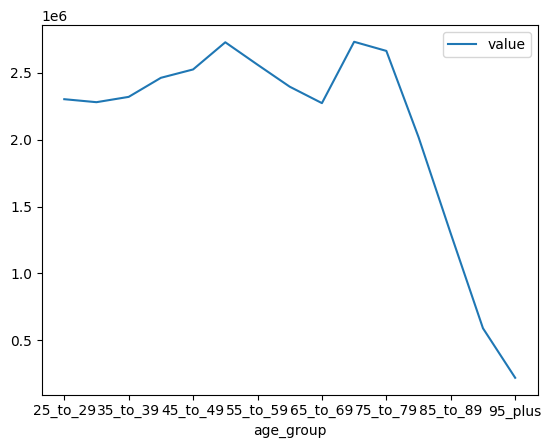

In [19]:
location = results.locations[3]
draw = results.draws[0]
year = 2040
sex = 'Female'
print(location, year, sex, draw)
results.person_time.query("location==@location and input_draw==@draw and event_year==@year and sex==@sex").plot('age_group', 'value');

# Test aggregation

In [62]:
pt_plus = results.append_aggregate_categories(results.person_time)
pt_plus

,location,sex,event_year,input_draw,value,age_group
0,United States of America,Female,2025,457,1.091295e+07,60_to_64
1,United States of America,Female,2025,169,1.123373e+07,60_to_64
2,United States of America,Female,2025,323,1.021452e+07,60_to_64
3,United States of America,Female,2026,457,1.081036e+07,60_to_64
4,United States of America,Female,2026,169,1.112822e+07,60_to_64
...,...,...,...,...,...,...
116275,Spain,Both,2100,457,1.831755e+07,60_plus
116276,Sweden,Both,2100,457,3.450488e+06,60_plus
116277,Taiwan (Province of China),Both,2100,457,8.974595e+06,60_plus
116278,United Kingdom,Both,2100,457,2.297988e+07,60_plus


In [21]:
results.person_time

,location,sex,event_year,input_draw,value,age_group
0,United States of America,Female,2025,457,1.121058e+07,25_to_29
1,United States of America,Female,2025,169,1.156020e+07,25_to_29
2,United States of America,Female,2025,323,1.051324e+07,25_to_29
3,United States of America,Female,2026,457,1.127173e+07,25_to_29
4,United States of America,Female,2026,169,1.162648e+07,25_to_29
...,...,...,...,...,...,...
68395,United Kingdom,Male,2100,169,3.839867e+05,90_to_94
68396,United Kingdom,Male,2100,323,3.869275e+05,90_to_94
68397,United Kingdom,Male,2100,457,1.446562e+05,95_plus
68398,United Kingdom,Male,2100,169,1.309761e+05,95_plus


In [66]:
68400 * 2

136800

In [63]:
pt_plus.age_group.unique()

['60_to_64', '65_to_69', '70_to_74', '75_to_79', '80_to_84', ..., '45_to_49', '50_to_54', '55_to_59', '60_plus', '25_plus']
Length: 17
Categories (17, object): ['25_to_29' < '30_to_34' < '35_to_39' < '40_to_44' ... '90_to_94' < '95_plus' < '25_plus' < '60_plus']

In [23]:
pt_plus.sex.unique()

['Female', 'Male', 'Both']
Categories (3, object): ['Female' < 'Male' < 'Both']

In [65]:
results.ops.value(pt_plus).index.duplicated().any()

False

# Load deaths

In [24]:
results.load_measure_from_batch_runs('deaths', filters=loading.FINAL_RESULTS_FILTERS['deaths'])

print(len(results.data.deaths), 'rows')
results.data.deaths.head()

Timer BatchLoadingTimer started
[('event_year', '>=', '2025'), ('entity', '=', 'alzheimers_disease_state')]
{'all': PosixPath('/mnt/team/simulation_science/pub/models/vivarium_csu_alzheimers/results/model8.7/model_spec/2025_11_05_15_36_29/results')}
{'United States of America': '/mnt/team/simulation_science/pub/models/vivarium_csu_alzheimers/artifacts/model8.3/united_states_of_america.hdf', 'Brazil': '/mnt/team/simulation_science/pub/models/vivarium_csu_alzheimers/artifacts/model8.3/brazil.hdf', 'China': '/mnt/team/simulation_science/pub/models/vivarium_csu_alzheimers/artifacts/model8.3/china.hdf', 'Germany': '/mnt/team/simulation_science/pub/models/vivarium_csu_alzheimers/artifacts/model8.3/germany.hdf', 'Israel': '/mnt/team/simulation_science/pub/models/vivarium_csu_alzheimers/artifacts/model8.3/israel.hdf', 'Japan': '/mnt/team/simulation_science/pub/models/vivarium_csu_alzheimers/artifacts/model8.3/japan.hdf', 'Spain': '/mnt/team/simulation_science/pub/models/vivarium_csu_alzheimers

,age_group,artifact_path,entity,entity_type,event_year,input_draw,measure,scenario,sex,value,location
0,25_to_29,/mnt/team/simulation_science/pub/models/vivari...,alzheimers_disease_state,cause,2025,169,deaths,baseline,Female,0.0,Japan
1,25_to_29,/mnt/team/simulation_science/pub/models/vivari...,alzheimers_disease_state,cause,2025,169,deaths,baseline,Male,0.0,Japan
2,25_to_29,/mnt/team/simulation_science/pub/models/vivari...,alzheimers_disease_state,cause,2025,169,deaths,bbbm_testing,Female,0.0,Japan
3,25_to_29,/mnt/team/simulation_science/pub/models/vivari...,alzheimers_disease_state,cause,2025,169,deaths,bbbm_testing,Male,0.0,Japan
4,25_to_29,/mnt/team/simulation_science/pub/models/vivari...,alzheimers_disease_state,cause,2025,169,deaths,bbbm_testing_and_treatment,Female,0.0,Japan


In [25]:
d = {
    'location': 10,
    'age_group': 15,
    'year': len(range(2025, 2101)),
    'draw': len(results.draws),
    'scenario': 3,
    'sex': 2,
}
math.prod(d.values())

205200

# Append aggregates to deaths

In [70]:
deaths_plus = results.append_aggregate_categories(results.data.deaths)
deaths_plus

,age_group,artifact_path,entity,entity_type,event_year,input_draw,measure,scenario,sex,value,location
0,60_to_64,/mnt/team/simulation_science/pub/models/vivari...,alzheimers_disease_state,cause,2025,169,deaths,baseline,Female,150.0,Japan
1,60_to_64,/mnt/team/simulation_science/pub/models/vivari...,alzheimers_disease_state,cause,2025,169,deaths,baseline,Male,84.0,Japan
2,60_to_64,/mnt/team/simulation_science/pub/models/vivari...,alzheimers_disease_state,cause,2025,169,deaths,bbbm_testing,Female,150.0,Japan
3,60_to_64,/mnt/team/simulation_science/pub/models/vivari...,alzheimers_disease_state,cause,2025,169,deaths,bbbm_testing,Male,84.0,Japan
4,60_to_64,/mnt/team/simulation_science/pub/models/vivari...,alzheimers_disease_state,cause,2025,169,deaths,bbbm_testing_and_treatment,Female,150.0,Japan
...,...,...,...,...,...,...,...,...,...,...,...
348835,60_plus,/mnt/team/simulation_science/pub/models/vivari...,alzheimers_disease_state,cause,2100,323,deaths,bbbm_testing,Both,219853.0,Brazil
348836,60_plus,/mnt/team/simulation_science/pub/models/vivari...,alzheimers_disease_state,cause,2100,323,deaths,bbbm_testing_and_treatment,Both,213727.0,Brazil
348837,60_plus,/mnt/team/simulation_science/pub/models/vivari...,alzheimers_disease_state,cause,2100,457,deaths,baseline,Both,279924.0,Brazil
348838,60_plus,/mnt/team/simulation_science/pub/models/vivari...,alzheimers_disease_state,cause,2100,457,deaths,bbbm_testing,Both,279924.0,Brazil


In [41]:
d = {
    'location': 10,
    'age_group': 17,
    'year': len(range(2025, 2101)),
    'draw': len(results.draws),
    'scenario': 3,
    'sex': 3,
}
math.prod(d.values())

348840

In [42]:
deaths_plus.query("age_group=='60_plus'")

,age_group,artifact_path,entity,entity_type,event_year,input_draw,measure,scenario,sex,value,location
218880,60_plus,/mnt/team/simulation_science/pub/models/vivari...,alzheimers_disease_state,cause,2025,169,deaths,baseline,Female,55269.0,Japan
218881,60_plus,/mnt/team/simulation_science/pub/models/vivari...,alzheimers_disease_state,cause,2025,169,deaths,baseline,Male,16261.0,Japan
218882,60_plus,/mnt/team/simulation_science/pub/models/vivari...,alzheimers_disease_state,cause,2025,169,deaths,bbbm_testing,Female,55269.0,Japan
218883,60_plus,/mnt/team/simulation_science/pub/models/vivari...,alzheimers_disease_state,cause,2025,169,deaths,bbbm_testing,Male,16261.0,Japan
218884,60_plus,/mnt/team/simulation_science/pub/models/vivari...,alzheimers_disease_state,cause,2025,169,deaths,bbbm_testing_and_treatment,Female,55269.0,Japan
...,...,...,...,...,...,...,...,...,...,...,...
348835,60_plus,/mnt/team/simulation_science/pub/models/vivari...,alzheimers_disease_state,cause,2100,323,deaths,bbbm_testing,Both,219853.0,Brazil
348836,60_plus,/mnt/team/simulation_science/pub/models/vivari...,alzheimers_disease_state,cause,2100,323,deaths,bbbm_testing_and_treatment,Both,213727.0,Brazil
348837,60_plus,/mnt/team/simulation_science/pub/models/vivari...,alzheimers_disease_state,cause,2100,457,deaths,baseline,Both,279924.0,Brazil
348838,60_plus,/mnt/team/simulation_science/pub/models/vivari...,alzheimers_disease_state,cause,2100,457,deaths,bbbm_testing,Both,279924.0,Brazil


In [58]:
dpv = results.ops.value(deaths_plus)
dpv

value
age_group artifact_path                                      entity                   entity_type event_year input_draw location measure scenario                   sex             
60_to_64  /mnt/team/simulation_science/pub/models/vivariu... alzheimers_disease_state cause       2025       169        Japan    deaths  baseline                   Female     150.0
                                                                                                                                                                    Male        84.0
                                                                                                                                         bbbm_testing               Female     150.0
                                                                                                                                                                    Male        84.0
                                                                                                                                         bbbm_testing_and_treatment Female     150.0
...                                                                                                                                                                              ...
60_plus   /mnt/team/simulation_science/pub/models/vivariu... alzheimers_disease_state cause       2100       323        Brazil   deaths  bbbm_testing               Both    219853.0
                                                                                                                                         bbbm_testing_and_treatment Both    213727.0
                                                                                                             457        Brazil   deaths  baseline                   Both    279924.0
                                                                                                                                         bbbm_testing               Both    279924.0
                                                                                                                                         bbbm_testing_and_treatment Both    272437.0

[348840 rows x 1 columns]

In [59]:
set(t[0] for t in dpv.loc[dpv.index.duplicated()].index)

set()

In [60]:
def count_unique(df, omit=['value', 'artifact_path']):
    return {name: c.nunique() for name, c in df.items() if name not in omit}

d = count_unique(deaths_plus)
print(math.prod(d.values()))
d

348840


{'age_group': 17,
 'entity': 1,
 'entity_type': 1,
 'event_year': 76,
 'input_draw': 3,
 'measure': 1,
 'scenario': 3,
 'sex': 3,
 'location': 10}

In [32]:
109440 + 348840

458280

In [33]:
d = count_unique(pt_plus)
print(math.prod(d.values()))
d

116280


{'location': 10, 'sex': 3, 'event_year': 76, 'input_draw': 3, 'age_group': 17}

In [67]:
death_rate = results.calculate_rate(deaths_plus, pt_plus)
death_rate

,age_group,event_year,input_draw,location,sex,artifact_path,entity,entity_type,measure,scenario,value,metric
0,25_plus,2025,169,Brazil,Both,/mnt/team/simulation_science/pub/models/vivari...,alzheimers_disease_state,cause,deaths,baseline,0.000398,Rate
1,25_plus,2025,169,Brazil,Both,/mnt/team/simulation_science/pub/models/vivari...,alzheimers_disease_state,cause,deaths,bbbm_testing,0.000398,Rate
2,25_plus,2025,169,Brazil,Both,/mnt/team/simulation_science/pub/models/vivari...,alzheimers_disease_state,cause,deaths,bbbm_testing_and_treatment,0.000398,Rate
3,25_plus,2025,169,Brazil,Female,/mnt/team/simulation_science/pub/models/vivari...,alzheimers_disease_state,cause,deaths,baseline,0.000548,Rate
4,25_plus,2025,169,Brazil,Female,/mnt/team/simulation_science/pub/models/vivari...,alzheimers_disease_state,cause,deaths,bbbm_testing,0.000548,Rate
...,...,...,...,...,...,...,...,...,...,...,...,...
348835,95_plus,2100,457,United States of America,Female,/mnt/team/simulation_science/pub/models/vivari...,alzheimers_disease_state,cause,deaths,bbbm_testing,0.007458,Rate
348836,95_plus,2100,457,United States of America,Female,/mnt/team/simulation_science/pub/models/vivari...,alzheimers_disease_state,cause,deaths,bbbm_testing_and_treatment,0.007536,Rate
348837,95_plus,2100,457,United States of America,Male,/mnt/team/simulation_science/pub/models/vivari...,alzheimers_disease_state,cause,deaths,baseline,0.004854,Rate
348838,95_plus,2100,457,United States of America,Male,/mnt/team/simulation_science/pub/models/vivari...,alzheimers_disease_state,cause,deaths,bbbm_testing,0.004854,Rate


In [68]:
print(len(deaths_plus), len(pt_plus), len(death_rate))
# 458280 152760 677160

348840 116280 348840


In [36]:
death_rate.value.isna().any()

False

In [37]:
677160 - 458280

218880

# Test some stuff for Vivarium Helpers code

In [39]:
sixty_plus_map = {
            '60_plus': [a for a in results.age_map['age_group'] if a >= '60_to_64']
            }

sixty_plus_map

{'60_plus': ['60_to_64',
  '65_to_69',
  '70_to_74',
  '75_to_79',
  '80_to_84',
  '85_to_89',
  '90_to_94',
  '95_plus']}

In [48]:
deaths_plus.query("age_group in @sixty_plus_map")

,age_group,artifact_path,entity,entity_type,event_year,input_draw,measure,scenario,sex,value,location
300960,60_plus,/mnt/team/simulation_science/pub/models/vivari...,alzheimers_disease_state,cause,2025,169,deaths,baseline,Female,55269.0,Japan
300961,60_plus,/mnt/team/simulation_science/pub/models/vivari...,alzheimers_disease_state,cause,2025,169,deaths,baseline,Male,16261.0,Japan
300962,60_plus,/mnt/team/simulation_science/pub/models/vivari...,alzheimers_disease_state,cause,2025,169,deaths,bbbm_testing,Female,55269.0,Japan
300963,60_plus,/mnt/team/simulation_science/pub/models/vivari...,alzheimers_disease_state,cause,2025,169,deaths,bbbm_testing,Male,16261.0,Japan
300964,60_plus,/mnt/team/simulation_science/pub/models/vivari...,alzheimers_disease_state,cause,2025,169,deaths,bbbm_testing_and_treatment,Female,55269.0,Japan
...,...,...,...,...,...,...,...,...,...,...,...
424075,60_plus,/mnt/team/simulation_science/pub/models/vivari...,alzheimers_disease_state,cause,2100,323,deaths,bbbm_testing,Both,219853.0,Brazil
424076,60_plus,/mnt/team/simulation_science/pub/models/vivari...,alzheimers_disease_state,cause,2100,323,deaths,bbbm_testing_and_treatment,Both,213727.0,Brazil
424077,60_plus,/mnt/team/simulation_science/pub/models/vivari...,alzheimers_disease_state,cause,2100,457,deaths,baseline,Both,279924.0,Brazil
424078,60_plus,/mnt/team/simulation_science/pub/models/vivari...,alzheimers_disease_state,cause,2100,457,deaths,bbbm_testing,Both,279924.0,Brazil


In [49]:
ag = 'age_group'
deaths_plus.query(f"{ag} in @sixty_plus_map")

,age_group,artifact_path,entity,entity_type,event_year,input_draw,measure,scenario,sex,value,location
300960,60_plus,/mnt/team/simulation_science/pub/models/vivari...,alzheimers_disease_state,cause,2025,169,deaths,baseline,Female,55269.0,Japan
300961,60_plus,/mnt/team/simulation_science/pub/models/vivari...,alzheimers_disease_state,cause,2025,169,deaths,baseline,Male,16261.0,Japan
300962,60_plus,/mnt/team/simulation_science/pub/models/vivari...,alzheimers_disease_state,cause,2025,169,deaths,bbbm_testing,Female,55269.0,Japan
300963,60_plus,/mnt/team/simulation_science/pub/models/vivari...,alzheimers_disease_state,cause,2025,169,deaths,bbbm_testing,Male,16261.0,Japan
300964,60_plus,/mnt/team/simulation_science/pub/models/vivari...,alzheimers_disease_state,cause,2025,169,deaths,bbbm_testing_and_treatment,Female,55269.0,Japan
...,...,...,...,...,...,...,...,...,...,...,...
424075,60_plus,/mnt/team/simulation_science/pub/models/vivari...,alzheimers_disease_state,cause,2100,323,deaths,bbbm_testing,Both,219853.0,Brazil
424076,60_plus,/mnt/team/simulation_science/pub/models/vivari...,alzheimers_disease_state,cause,2100,323,deaths,bbbm_testing_and_treatment,Both,213727.0,Brazil
424077,60_plus,/mnt/team/simulation_science/pub/models/vivari...,alzheimers_disease_state,cause,2100,457,deaths,baseline,Both,279924.0,Brazil
424078,60_plus,/mnt/team/simulation_science/pub/models/vivari...,alzheimers_disease_state,cause,2100,457,deaths,bbbm_testing,Both,279924.0,Brazil


In [50]:
f"{ag} in @sixty_plus_map"

'age_group in @sixty_plus_map'

In [56]:
if ...:
    print(...)

Ellipsis


In [54]:
vh.utils.list_columns('a', ['b', 'c'])

['a', 'b', 'c']

In [55]:
set('abc')

{'a', 'b', 'c'}

# Create new results object and compute person-time including aggregated categories

In [101]:
r1 = AlzheimersResultsProcessor('8.3', RunType.FINAL, batch_run_dirs=batch_run_dirs)

In [102]:
r1.load_population_data(append_aggregates=True)
r1.person_time

,location,sex,event_year,input_draw,value,age_group
0,United States of America,Female,2025,457,1.091295e+07,60_to_64
1,United States of America,Female,2025,169,1.123373e+07,60_to_64
2,United States of America,Female,2025,323,1.021452e+07,60_to_64
3,United States of America,Female,2026,457,1.081036e+07,60_to_64
4,United States of America,Female,2026,169,1.112822e+07,60_to_64
...,...,...,...,...,...,...
109435,Spain,Both,2100,457,1.831755e+07,60_plus
109436,Sweden,Both,2100,457,3.450488e+06,60_plus
109437,Taiwan (Province of China),Both,2100,457,8.974595e+06,60_plus
109438,United Kingdom,Both,2100,457,2.297988e+07,60_plus


In [103]:
deaths_prepped = r1.process_deaths(results.data.deaths)
deaths_prepped

5.751104 MB measure
1.920704 MB minuend
3.835904 MB subtrahend
1.240107 MB minuend re-indexed
2.471307 MB subtrahend re-indexed
2.471367 MB difference
4.383236 MB difference with reset index
4.520361 MB final difference


,age_group,artifact_path,entity,entity_type,event_year,input_draw,measure,scenario,sex,value,location,metric,disease_stage
0,25_to_29,/mnt/team/simulation_science/pub/models/vivari...,alzheimers_disease_state,cause,2025,169,Deaths Associated with AD,baseline,Female,0.0,Japan,Number,alzheimers_disease_state
1,25_to_29,/mnt/team/simulation_science/pub/models/vivari...,alzheimers_disease_state,cause,2025,169,Deaths Associated with AD,baseline,Male,0.0,Japan,Number,alzheimers_disease_state
2,25_to_29,/mnt/team/simulation_science/pub/models/vivari...,alzheimers_disease_state,cause,2025,169,Deaths Associated with AD,bbbm_testing,Female,0.0,Japan,Number,alzheimers_disease_state
3,25_to_29,/mnt/team/simulation_science/pub/models/vivari...,alzheimers_disease_state,cause,2025,169,Deaths Associated with AD,bbbm_testing,Male,0.0,Japan,Number,alzheimers_disease_state
4,25_to_29,/mnt/team/simulation_science/pub/models/vivari...,alzheimers_disease_state,cause,2025,169,Deaths Associated with AD,bbbm_testing_and_treatment,Female,0.0,Japan,Number,alzheimers_disease_state
...,...,...,...,...,...,...,...,...,...,...,...,...,...
341995,95_plus,/mnt/team/simulation_science/pub/models/vivari...,alzheimers_disease_state,cause,2100,323,Averted Deaths Associated with AD,bbbm_testing_and_treatment,Male,-152.0,Brazil,Number,alzheimers_disease_state
341996,95_plus,/mnt/team/simulation_science/pub/models/vivari...,alzheimers_disease_state,cause,2100,457,Averted Deaths Associated with AD,bbbm_testing,Female,0.0,Brazil,Number,alzheimers_disease_state
341997,95_plus,/mnt/team/simulation_science/pub/models/vivari...,alzheimers_disease_state,cause,2100,457,Averted Deaths Associated with AD,bbbm_testing,Male,0.0,Brazil,Number,alzheimers_disease_state
341998,95_plus,/mnt/team/simulation_science/pub/models/vivari...,alzheimers_disease_state,cause,2100,457,Averted Deaths Associated with AD,bbbm_testing_and_treatment,Female,-894.0,Brazil,Number,alzheimers_disease_state


In [104]:
deaths_prepped.age_group.unique()

['25_to_29', '30_to_34', '35_to_39', '40_to_44', '45_to_49', ..., '75_to_79', '80_to_84', '85_to_89', '90_to_94', '95_plus']
Length: 15
Categories (15, object): ['25_to_29' < '30_to_34' < '35_to_39' < '40_to_44' ... '80_to_84' < '85_to_89' < '90_to_94' < '95_plus']

In [ ]:
deaths_output = r1.summarize_and_beautify(deaths_prepped, 'entity')
deaths_output
# 387600 rows with 60+ and 25+ age groups
# 364800 rows with 60+ only

Timer SummarizingTimer started
2025-11-24 20:15:04.313428
2025-11-24 20:15:07.677524
2025-11-24 20:23:09.948352
Elapsed time: 485.6454 seconds


,Year,Location,Age,Sex,Disease Stage,Scenario,Measure,Metric,Mean,95% UI Lower,95% UI Upper
0,2025,Brazil,60_to_64,Female,AD Dementia,Reference,Deaths Associated with AD,Number,832.325436,801.009230,861.835556
1,2025,Brazil,60_to_64,Male,AD Dementia,Reference,Deaths Associated with AD,Number,375.995746,329.749119,425.526104
2,2025,Brazil,60_to_64,Both,AD Dementia,Reference,Deaths Associated with AD,Number,1208.321182,1130.758349,1287.361661
3,2025,Brazil,60_to_64,Female,AD Dementia,BBBM Testing Only,Deaths Associated with AD,Number,832.325436,801.009230,861.835556
4,2025,Brazil,60_to_64,Male,AD Dementia,BBBM Testing Only,Deaths Associated with AD,Number,375.995746,329.749119,425.526104
...,...,...,...,...,...,...,...,...,...,...,...
364795,2100,United States of America,60_plus,Male,AD Dementia,BBBM Testing Only,Averted Deaths Associated with AD,Rate,0.000000,0.000000,0.000000
364796,2100,United States of America,60_plus,Both,AD Dementia,BBBM Testing Only,Averted Deaths Associated with AD,Rate,0.000000,0.000000,0.000000
364797,2100,United States of America,60_plus,Female,AD Dementia,BBBM Testing and Treatment,Averted Deaths Associated with AD,Rate,0.000057,0.000046,0.000071
364798,2100,United States of America,60_plus,Male,AD Dementia,BBBM Testing and Treatment,Averted Deaths Associated with AD,Rate,0.000030,0.000025,0.000036


In [106]:
deaths_output.Mean.isna().any()

False

In [107]:
# d = count_unique(deaths_output, omit=['value', 'artifact_path', 'scenario'])
d = count_unique(deaths_output, omit=['Mean', '95% UI Lower', '95% UI Upper'])
print(math.prod(d.values()))
d

437760


{'Year': 76,
 'Location': 10,
 'Age': 16,
 'Sex': 3,
 'Disease Stage': 1,
 'Scenario': 3,
 'Measure': 2,
 'Metric': 2}

In [108]:
deaths_output.Measure.value_counts()

Deaths Associated with AD            218880
Averted Deaths Associated with AD    145920
Name: Measure, dtype: int64

In [109]:
145920 * 3 / 2

218880.0

In [ ]:
# Each scenario+measure combination should have the same number of rows
deaths_output.value_counts(['Scenario', 'Measure'])

Scenario                    Measure                          
Reference                   Deaths Associated with AD            72960
BBBM Testing Only           Averted Deaths Associated with AD    72960
                            Deaths Associated with AD            72960
BBBM Testing and Treatment  Averted Deaths Associated with AD    72960
                            Deaths Associated with AD            72960
dtype: int64

In [111]:
72960 * 5

364800

In [112]:
!pip freeze | grep vivarium

vivarium==3.4.12
vivarium_build_utils==2.0.4
vivarium_cluster_tools==2.1.17
-e git+https://github.com/ihmeuw/vivarium_csu_alzheimers.git@263eb3d9b80b13735a7380bb892430eaba92603a#egg=vivarium_csu_alzheimers
vivarium_dependencies==1.0.1
vivarium_gbd_access==4.2.4
-e git+https://github.com/ihmeuw/vivarium_helpers.git@df1d7a613111eafa73bcdf24ba3fcb7cff224c7f#egg=vivarium_helpers
vivarium_inputs==6.0.4
vivarium_public_health==4.3.5


In [ ]:
!conda list | grep vivarium

# packages in environment at /ihme/homes/ndbs/miniconda3/envs/vivarium_csu_alzheimers_artifact:
vivarium                  3.4.12                   pypi_0    pypi
vivarium-build-utils      2.0.4                    pypi_0    pypi
vivarium-cluster-tools    2.1.17                   pypi_0    pypi
vivarium-csu-alzheimers   0.1.dev18+g43e997c.d20250808          pypi_0    pypi
vivarium-dependencies     1.0.1                    pypi_0    pypi
vivarium-gbd-access       4.2.4                    pypi_0    pypi
vivarium-helpers          0.2.0                     dev_0    <develop>
vivarium-inputs           6.0.4                    pypi_0    pypi
vivarium-public-health    4.3.5                    pypi_0    pypi


In [117]:
0xdf1d7a613111eafa73bcdf24ba3fcb7cff224c7f

1273762324275972074822980425489639229362427546751

In [118]:
int('df1d7a613111eafa73bcdf24ba3fcb7cff224c7f', 16)

1273762324275972074822980425489639229362427546751